# IBM HR Analytics Employee Attrition & Performance
- 직원의 이직 여부 예측 분류 모델
- https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset

In [46]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("employee-attrition").getOrCreate()

# csv 파일 로드
df = spark.read.csv('../learning_spark_data/WA_Fn-UseC_-HR-Employee-Attrition.csv', header=True, inferSchema=True)
df.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Attrition: string (nullable = true)
 |-- BusinessTravel: string (nullable = true)
 |-- DailyRate: integer (nullable = true)
 |-- Department: string (nullable = true)
 |-- DistanceFromHome: integer (nullable = true)
 |-- Education: integer (nullable = true)
 |-- EducationField: string (nullable = true)
 |-- EmployeeCount: integer (nullable = true)
 |-- EmployeeNumber: integer (nullable = true)
 |-- EnvironmentSatisfaction: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- HourlyRate: integer (nullable = true)
 |-- JobInvolvement: integer (nullable = true)
 |-- JobLevel: integer (nullable = true)
 |-- JobRole: string (nullable = true)
 |-- JobSatisfaction: integer (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- MonthlyIncome: integer (nullable = true)
 |-- MonthlyRate: integer (nullable = true)
 |-- NumCompaniesWorked: integer (nullable = true)
 |-- Over18: string (nullable = true)
 |-- OverTime: string 

In [47]:
df.select('EmployeeNumber').show(5)
df.select('EmployeeCount').show(5)

+--------------+
|EmployeeNumber|
+--------------+
|             1|
|             2|
|             4|
|             5|
|             7|
+--------------+
only showing top 5 rows

+-------------+
|EmployeeCount|
+-------------+
|            1|
|            1|
|            1|
|            1|
|            1|
+-------------+
only showing top 5 rows



In [48]:
# 불필요한 컬럼 제거: 'EmployeeNumber', 'EmployeeCount', 'Over18', 'StandardHours'
# - 'EmployeeCount', 'StandardHours': 모든 값이 동일하므로 모델 학습에 도움이 되지 않음
# - 'Over18': 모든 값이 'Y'로 동일 → 정보 없음
# - 'EmployeeNumber': 고유 식별자 역할 → 예측에 영향을 주지 않음

drop_cols = ['EmployeeNumber', 'EmployeeCount', 'Over18', 'StandardHours']
hr_df = df.drop(*drop_cols)

In [49]:
hr_df.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Attrition: string (nullable = true)
 |-- BusinessTravel: string (nullable = true)
 |-- DailyRate: integer (nullable = true)
 |-- Department: string (nullable = true)
 |-- DistanceFromHome: integer (nullable = true)
 |-- Education: integer (nullable = true)
 |-- EducationField: string (nullable = true)
 |-- EnvironmentSatisfaction: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- HourlyRate: integer (nullable = true)
 |-- JobInvolvement: integer (nullable = true)
 |-- JobLevel: integer (nullable = true)
 |-- JobRole: string (nullable = true)
 |-- JobSatisfaction: integer (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- MonthlyIncome: integer (nullable = true)
 |-- MonthlyRate: integer (nullable = true)
 |-- NumCompaniesWorked: integer (nullable = true)
 |-- OverTime: string (nullable = true)
 |-- PercentSalaryHike: integer (nullable = true)
 |-- PerformanceRating: integer (nullable = true)
 |-- Relation

In [50]:
# 결측치 확인
from pyspark.sql.functions import col, sum
hr_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in hr_df.columns]).show()

+---+---------+--------------+---------+----------+----------------+---------+--------------+-----------------------+------+----------+--------------+--------+-------+---------------+-------------+-------------+-----------+------------------+--------+-----------------+-----------------+------------------------+----------------+-----------------+---------------------+---------------+--------------+------------------+-----------------------+--------------------+
|Age|Attrition|BusinessTravel|DailyRate|Department|DistanceFromHome|Education|EducationField|EnvironmentSatisfaction|Gender|HourlyRate|JobInvolvement|JobLevel|JobRole|JobSatisfaction|MaritalStatus|MonthlyIncome|MonthlyRate|NumCompaniesWorked|OverTime|PercentSalaryHike|PerformanceRating|RelationshipSatisfaction|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|WorkLifeBalance|YearsAtCompany|YearsInCurrentRole|YearsSinceLastPromotion|YearsWithCurrManager|
+---+---------+--------------+---------+----------+----------------+--

In [51]:
# 각 컬럼별 결측치 개수 확인 -> 모든 컬럼 결측치 없음 확인

In [52]:
hr_df.groupBy('Attrition').count().show()

+---------+-----+
|Attrition|count|
+---------+-----+
|       No| 1233|
|      Yes|  237|
+---------+-----+



In [53]:
# 타겟 변수 'Attrition' Yes/No → 이진 분류를 위한 숫자형 레이블로 변환
# Yes → 1, No → 0
from pyspark.ml.feature import StringIndexer
label_indexer = StringIndexer(inputCol='Attrition', outputCol='label')

In [54]:
# 범주형 변수 처리 (StringIndexer + OneHotEncoder)
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline
cat_features = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']
cat_stages = []

for col in cat_features:
    indexer = StringIndexer(inputCol=col, outputCol=col+'_idx').setHandleInvalid('keep')
    encoder = OneHotEncoder(inputCols=[col+'_idx'], outputCols=[col+'_onehot'])
    cat_stages += [indexer, encoder]

In [55]:
# 수치형 변수 정규화 (StandardScaler)
from pyspark.ml.feature import StandardScaler, VectorAssembler
num_features = [
    'Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction',
    'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction',
    'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike',
    'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel',
    'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
    'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager'
]

num_vector_stages = []
for col in num_features:
    assembler = VectorAssembler(inputCols=[col], outputCol=col+'_vec')
    scaler = StandardScaler(inputCol=col+'_vec', outputCol=col+'_scaled')
    num_vector_stages += [assembler, scaler]

In [56]:
# feature 벡터: One-hot + scaled 숫자 합치기
assembler_input = [f"{col}_onehot" for col in cat_features] + [f"{col}_scaled" for col in num_features]
assembler = VectorAssembler(inputCols=assembler_input, outputCol='features')

In [57]:
# 파이프라인 생성
from pyspark.ml import Pipeline
stages = [label_indexer] + cat_stages + num_vector_stages + [assembler]
pipeline = Pipeline(stages=stages)

In [77]:
# train/test 데이터 분할 + 변환
train_df, test_df = hr_df.randomSplit([0.8, 0.2], seed=42)
fitted_pipeline = pipeline.fit(train_df)

vtrain_df = fitted_pipeline.transform(train_df)
vtest_df = fitted_pipeline.transform(test_df)

In [78]:
# 로지스틱 모델 학습
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol='features', labelCol='label')
model = lr.fit(vtrain_df)

In [79]:
# 예측
pred = model.transform(vtest_df)
pred.select('label', 'prediction', 'probability').show(5)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|[0.94870661941285...|
|  1.0|       1.0|[0.04299373762790...|
|  0.0|       0.0|[0.62934194403841...|
|  1.0|       0.0|[0.68632874187752...|
|  0.0|       1.0|[0.34984687439081...|
+-----+----------+--------------------+
only showing top 5 rows



In [80]:
# 평가
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(pred)

0.8059542796384893

In [81]:
# 중요 피처 확인
# 계수 추출
coefficients = model.coefficients.toArray()

# 피처 이름 추출
feature_names = assembler.getInputCols()

# 피처와 계수를 묶어서 정렬 (절댓값 기준)
coeff_df = [(name, coef) for name, coef in zip(feature_names, coefficients)]
coeff_df_sorted = sorted(coeff_df, key=lambda x: abs(x[1]), reverse=True)

# 상위 20개 출력
for name, coef in coeff_df_sorted[:20]:
    print(f"{name:<30} | {coef:.4f}")


RelationshipSatisfaction_scaled | -13.3460
StockOptionLevel_scaled        | 10.5734
MaritalStatus_onehot           | -8.6822
PerformanceRating_scaled       | 1.7366
EducationField_onehot          | -1.2011
MonthlyIncome_scaled           | 1.0465
YearsAtCompany_scaled          | -1.0163
YearsInCurrentRole_scaled      | 1.0163
Department_onehot              | 0.8886
Gender_onehot                  | 0.8627
JobLevel_scaled                | 0.7932
JobRole_onehot                 | 0.7193
MonthlyRate_scaled             | -0.6885
EnvironmentSatisfaction_scaled | 0.6746
DistanceFromHome_scaled        | 0.6731
TrainingTimesLastYear_scaled   | 0.5354
WorkLifeBalance_scaled         | -0.4471
DailyRate_scaled               | 0.3570
NumCompaniesWorked_scaled      | -0.3350
OverTime_onehot                | -0.2978


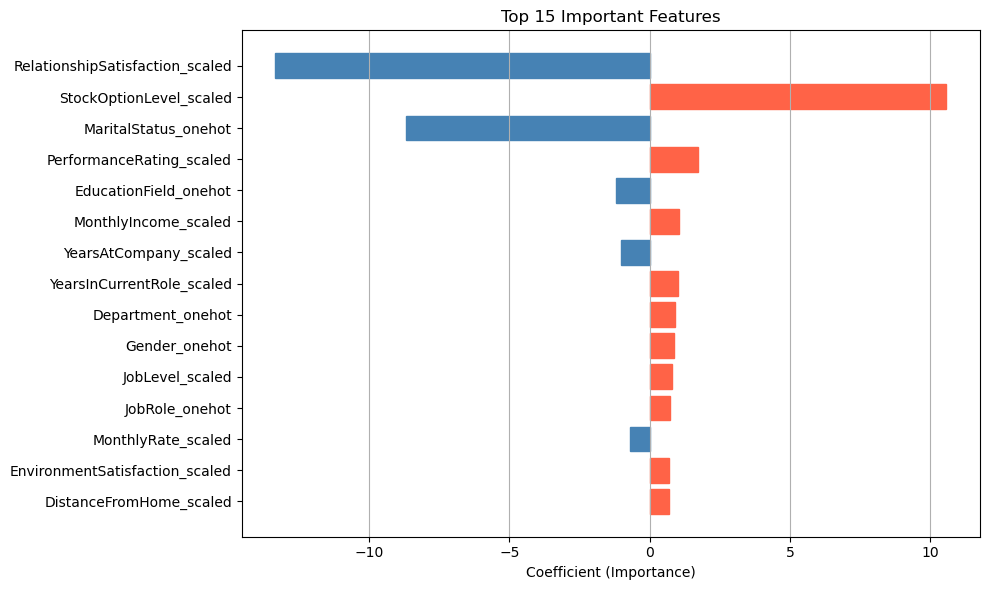

In [83]:
import matplotlib.pyplot as plt

# top N만 시각화
top_n = 15
top_features = coeff_df_sorted[:top_n]
names = [x[0] for x in top_features]
values = [x[1] for x in top_features]

# 막대 그래프
plt.figure(figsize=(10, 6))
bars = plt.barh(names[::-1], values[::-1])  # reverse for top-down

# 색상 강조
for bar in bars:
    bar.set_color('tomato' if bar.get_width() > 0 else 'steelblue')

plt.xlabel("Coefficient (Importance)")
plt.title("Top 15 Important Features")
plt.grid(axis='x')
plt.tight_layout()
plt.show()


In [ ]:
# 주요 변수 해석
# 음수 -> 퇴사 확률 낮추는 변수
# 양수 -> 퇴사 확률 높이는 변수
# 직장 내 인간관계 만족도가 높을수록 이직 확률 낮음